# Disney+ launch in Brazil: analyzing conversations on Twitter

This analysis aims to understand the conversations on Twitter about the Disney+ app launch in Brazil. The official launch happend on November 17th 2020, but the data presented here captures posts from 10 to 19 November.

The goal is to have an overview of the reactions about the app and its content.

These are of the main topics we are going to explore:

- Who talked about DispleyPlus? 
    - most engaged users 
    - verified accounts
    - most followed accounts
    <br/><br/>
- What did people say about it? 

    - Number of posts peaks and specific events that may be related to them
    - Keywords
    - Entities
    



Important notes about the data:
    
- Twitter API returns data considering UTC timezone. The offical Brasilia timezone is -3 UTC. So data appears here with an addition of 3 hours.
- Twitter API does not return all data from each day, but a mix from popular and recent tweets. 
- Specifications of the query: keyword:"DisneyPlus", language: "pt"

## Opening data

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import networkx as nx
import itertools
import nltk
import 

from IPython.core.interactiveshell import InteractiveShell

In [3]:
#Reading data that was already been concatenated and a preprocessed
data = pd.read_pickle(r'C:\Users\amand\Documents\GitHub\DisneyPlus\data_fulltext_pkl\disneyplus_concat_data.pkl')

In [4]:
#Structure of the data
data.shape

(66127, 19)

In [5]:
#Display the tweet full text
pd.set_option('display.max_colwidth', None)

#Show more than one output
InteractiveShell.ast_node_interactivity = "all"

## Treating null values

In [6]:
data.isnull().sum()

index                             0
user_screen_name                  0
user_id                           0
user_is_verified                  0
retweeted_from_screen_name    21852
retweeted_from_id                 0
retweeted_from_is_verified    21852
screen_name_mention_1         15123
id_mention_1                      0
in_reply_to_screen_name           0
in_reply_to_user_id               0
created_at                        0
id                                0
full_text                         0
retweet_full_text             21852
retweet_count                     0
favorite_count                    0
user_followers                    0
user_following                    0
dtype: int64

In [7]:
#Fill in null values with 0 so it doesnt interfere at the id columns.
data = data.fillna(0)

## Creating subsets

We consider retweets a kind of interaction that takes less effort to happen. Therefore, we decided to create a separete dataset containing only replies and mentions so we can evaluate engagement in a different way. 
<br/><br/>

We are also going to create a subset containing only posts from verified acoounts. This way we can evaluate the action of official channels and brands.

In [8]:
## Data without RTs
mask_no_rt = data['retweeted_from_id'] == 0
data_no_rt = data[mask_no_rt]
data_no_rt.shape

(21852, 19)

In [9]:
## Data without RTs and replies(to get mentions that do not correspond to RTs nor replies)
mask_no_rt_no_replies = (data['retweeted_from_id'] == 0) & (data['in_reply_to_user_id'] == 0) & (data['screen_name_mention_1'] != 0)
data_no_rt_no_replies = data[mask_no_rt_no_replies]
data_no_rt_no_replies.shape

(2079, 19)

- Subsets for verified accounts

In [10]:
## Data without RTs, only verified accounts
data_verified = data[data['user_is_verified'] == True]
data_verified.shape

(1356, 19)

## Getting Connections

We are going to explore graph visualizations and algorithms. For that, we have to capture the connections between users based on mentions, retweets and replies. Each of these interactions will represent a link between two users in a graph visualization.

In [109]:
#Defining function to get connections between users
def get_interactions(df_rts_replies, df_mentions):
    
    #List of tuples to build the graphs
    interactions_retweets = []
    interactions_mentions = []
    interactions_replies = []

    #Iterate over the complete dataset to get retweets and replies    
    for index, row in df_rts_replies.iterrows():
        user_sn = row['user_screen_name']
        retweet_from = row['retweeted_from_screen_name']
        reply_to = row['in_reply_to_screen_name']     
        
        interactions_retweets.append((user_sn, retweet_from))
        interactions_replies.append((user_sn, reply_to))

    #Iterate over subset containg only posts that were not a reply nor a retweet        
    for index, row in df_mentions.iterrows():
        user_sn = row['user_screen_name']
        mention = row['screen_name_mention_1']
        
        
        interactions_mentions.append((user_sn, mention))

    #Discard interactions with null values        
    interactions_rt_cleaned = [x for x in interactions_retweets if 0 not in x]
    interactions_mt_cleaned = [x for x in interactions_mentions if 0 not in x]
    interactions_rp_cleaned = [x for x in interactions_replies if 0 not in x]
    
    interactions_rt = list(set(interactions_rt_cleaned))
    interactions_mt = list(set(interactions_mt_cleaned))
    interactions_rp = list(set(interactions_rp_cleaned))
    
    
    return interactions_rt, interactions_mt, interactions_rp
        

- All posts

In [110]:
#Getting interactions, all data
retweets, mentions, replies = get_interactions(data, data_no_rt_no_replies)


- Posts from verified accounts

In [15]:
#Getting interactions from verified accounts
verified_rts, verified_mts, verified_rps = get_interactions(data_verified)

## Creating Graphs for visualizations

In [112]:
#Function to create graph with parallel edges
def create_and_add_edges(retweets, mentions, replies):
    
    G = nx.MultiDiGraph()

    G.add_edges_from(retweets, Type='retweet')
    G.add_edges_from(mentions, Type='mention')
    G.add_edges_from(replies, Type='reply')
    
    return G

In [113]:
#Graph with all interactions
G = create_and_add_edges(retweets, mentions, replies)

#Number of nodes considering all interactions
len(G.nodes.data())

#nx.write_gexf(G, "multigraph_all_data_rts.gexf")

35826

In [19]:
#Graph excluding RTs, only mentions and replies
H = create_and_add_edges(retweets=[], mentions, replies)

#Number of nodes excluding RTs
len(H.nodes.data())

#nx.write_gexf(H, "network_no_rt.gexf")

6422

In [20]:
#Graph considering all interections from verified accounts 
V = create_and_add_edges(verified_com_rts,verified_com_mts,verified_com_rps)

#Number of nodesexcluding RTs
len(V.nodes.data())

1138

## Analysis

The data will be analyzed from two main perspectives:

- Users Interactions
- Number of tweets
- Content

## Users

### **Unique users: how many people participated on the conversation?**


Due to API's restrictions, we didn't collect all the posts. During the data collection, we notice that even though it was not possible to have all the tweets, the data captured mantained a certain pattern in the distribution. Because of that, the percetage of users that only retweeted may be representative.

In [103]:
# Unique users with no interactions
no_it = (data['retweeted_from_id'] == 0) & (data['in_reply_to_user_id'] == 0) & (data['id_mention_1'] == 0)
no_int_users = set(data[no_it].user_id)

print(f'No interecation users: {len(no_int_users)}') #unique users sem interacao

#Any interaction
rt_rp_mt= (data['retweeted_from_id'] != 0) | (data['in_reply_to_user_id'] != 0) | (data['id_mention_1'] != 0)
outros = set(data[outs].user_id)
print(f'Users that retweeted, replied or mentioned: {len(outros)}')

#Teve gente que nao interagiu com ninguem?
meio = no_int_users.intersection(outros)
print(f'Users that had posts with no interactions but also retweeted, replied or mentioned: {len(meio)}')

#Users thar didnt interact

users_no_interaction =  no_int_users.difference(meio)
len(users_no_interaction)

No interecation users: 10686
Users that retweeted, replied or mentioned: 32515
Users that had posts with no interactions but also retweeted, replied or mentioned: 1992


8694

In [107]:
rt_mentions = set(data[data['retweeted_from_id'] != 0].user_id)

reply_mentions = set(data[data['in_reply_to_user_id'] != 0].user_id)

ment = set(data[(data['retweeted_from_id'] == 0) & (data['in_reply_to_user_id'] == 0) & (data['id_mention_1'] != 0)].user_id)

unique_users_any_interaction = rt_mentions|reply_mentions|ment


#Retweets, Mentions and Replies
AB_ABC = rt_mentions.intersection(reply_mentions)
len(AB_ABC)

#Retweets and Mentions
A_AC = rt_mentions.difference(AB_ABC)
len(A_AC)

#Replies and Mentions
B_BC = reply_mentions.difference(AB_ABC)
len(B_BC)

#Only Mentions
C = unique_users_any_interaction.difference(rt_mentions|reply_mentions)
len(C)

check = AB_ABC| A_AC | B_BC | C | users_no_interaction
len(check)

check == set(data.user_id)

354

28811

2028

1322

41209

True

In [104]:
fig = px.pie(values=[len(A_AC), len(B_BC), len(C), len(AB_ABC), len(users_no_interaction)], names=["Retweets/Mentions", "Replies/Mentions", "Only Mentions", "Retweets, Mentions and Replies", "No interactions"], 
       title='Unique Users', color_discrete_sequence= ["blue", "orange", "red", "yellow", "green"])

fig.update_layout(
    width=500,
    height=500)

### **Users network: all interactions**

In [114]:
## Graph Statistics: in-degree and link analysis

#In Degree
in_degree = nx.in_degree_centrality(G)
top_indegree = sorted(in_degree.items(), key=lambda item: item[1], reverse=True)[:10]
top_indegree



[('sickofthisnoise', 0.1511235170969993),
 ('DisneyPlusBR', 0.09549197487787857),
 ('df_porto', 0.05856245638520586),
 ('taylorxexile', 0.04164689462665736),
 ('JaumGodoy', 0.0410327983251919),
 ('wonzdvr', 0.02780181437543615),
 ('disneyplus', 0.026629448709002093),
 ('anafreitaax_', 0.022191207257501743),
 ('Nandagaah', 0.015464061409630145),
 ('15amanda8', 0.014068387997208652)]

### **Most followed users**

We can observe that there are different kinds of users/accounts in this list: streaming services(globoplay, DisneyPlusBR), e-commerce(MercadoLivre), app store(GooglePlay), guides (guiadisneyplus, disneygobr), fan accounts for the tv show Bia (nessavcb, irmasurquiza), k-pop fans(GIFT4EHYUNG, pjmsmilez, PRINC3JIKK).

In [115]:
most_followed_2 = data[['user_screen_name','user_followers']].drop_duplicates(subset='user_screen_name').sort_values(by='user_followers', ascending=False)[:10].set_index('user_screen_name')

fig2 = px.bar(most_followed_2, orientation='h')

fig2

### **Most engaged users, excluding RTs**

Globoplay and Disney+ made a partership allowing customers to sign up for both of their services for a special price. Considering the number of tweets about it and excluding the retweets, we can observe that Globoplay invested in interactions with their potential customers.

The tweets reveal another partnership, this time with Mercado Livre, an e-commerce platform. The offer included up to 6 months of Disney+ for free for customers with a certain number of points on its loyalty program, called Mercado Pontos.

DisneyPlusHelp

It is interesting to see how other companies took advantage of the launch to promote their on apps or products.

In [116]:
fig3 = px.bar(data_no_rt.user_screen_name.value_counts().head(15))
fig3

In this network we excluded retweets and considered only mentions and replies as a source for the edges.
To emphasize the interactions of the accounts, we set the node size according to the out-degree.
This visualization adds to the chart above, 

In [ ]:
%%html
<img src="Force_Atlas_in_degree.png" width=500 height=500 />

- **Number of tweets from verified accounts**

Some accounts were expected to appear on that list, because they are Disney+ partners: 
- RedeGlobo, for example, is the company that owns GloboPlay, a sreaming service that made a partnetship with Disney+.
- Claudia Leitte and Dani Calabresa are brazilian artists who participated on the special show produced for the app launch in Brazil.
- FoxSportsBrazil and ESPN are part of the Disney Companies.

We can also see media and journalists specialized on movies/tv:
- Omelete is a blog specialized on movies and tv.
- Antonio Tabet is a screenwriter



In [117]:
#Verified accounts sorted by number of tweets, excluding RTs
verified = data['user_is_verified'] == True
px.bar(data[verified]['user_screen_name'].value_counts().head(20).to_frame(), orientation='h')

- **Interactions from verified accounts**

In [ ]:
%%html
<img src="Force_Atlas_in_degree.png" width=500 height=500 />

## 2.2 Content

- **Most retweetd and liked tweets**


- One of the most retweeted publications was about caracteristcs of the old movies tapes

- People promising disney accounts for free

- Asking about others people accounts





In [156]:
#Most retweeted publication
data.sort_values('retweet_count', ascending=False).head(1).retweet_full_text.to_frame()

,retweet_full_text
37265,"GALERA, AVISO:\nAntes de dar play em qualquer filme do #DisneyPlus, favor VERIFICAR:\n- A marca indelével na parte superior;\n- O selo da UBV na lombada;\n- O holograma com o Mickey Feiticeiro; https://t.co/aN8O29e5TD"


In [157]:
# Most liked publication 
data.sort_values('favorite_count', ascending=False).head(1).full_text.to_frame()

,full_text
16958,"O grande dia finalmente chegou. E este post talvez seja a última coisa que você vai ver antes de entrar no #DisneyPlus, então, aproveitando: use #QueroVerPrimeiro e conte pra gente o que você vai ver! 😉 https://t.co/2ctqjHlyNS"


- **Tweets histogram**

In [ ]:
#Historgram considering all data
px.histogram(data.created_at, labels="")

- **Analyzing Peaks**

Nov 12: from 17 to 18 pm

    Reactions to the realease of the official date of the new Marvel Series Wanda Division
   
    
Nov 15: from 2 to 3 am

    People were commenting about Disney+ special launching content that was available on several channels such as YouTube and the streaming service of brazilian tv channel GloboPlay   
    
    
Nov 17: from 3 to 4 am

    The countdown for the app realease.
    Some fans seemed disappointed because the app was not realeased at midnight.
    
Nov 17: from 12 to 13 pm

    Official launch: content available   
    

mask1= (data['created_at'] > '2020-11-12 17:00:00') & (data['created_at'] <= '2020-11-12 17:59:59')
data[mask1].sort_values(by='favorite_count', ascending=False).full_text.head().to_frame()

mask2 = (data['created_at'] > '2020-11-15 02:00:00') & (data['created_at'] <= '2020-11-15 02:59:59')
data[mask2].sort_values(by='favorite_count', ascending=False).full_text.head().to_frame()

mask3 = (data['created_at'] > '2020-11-17 03:00:00') & (data['created_at'] <= '2020-11-17 03:59:59')
data[mask3].sort_values(by='favorite_count', ascending=False).full_text.head(10).to_frame()

mask4 = (data['created_at'] > '2020-11-17 12:00:00') & (data['created_at'] <= '2020-11-17 12:59:59')
data[mask4].sort_values(by='favorite_count', ascending=False).full_text.head().to_frame()

mask5 = (data['created_at'] > '2020-11-17 15:00:00') & (data['created_at'] <= '2020-11-17 15:59:59')
data[mask5].sort_values(by='favorite_count', ascending=False).full_text.head().to_frame()


## Nov 18 from 0 to 1 am

mask6 = (data['created_at'] > '2020-11-18 00:00:00') & (data['created_at'] <= '2020-11-18 00:59:59')
data[mask6].sort_values(by='favorite_count', ascending=False).full_text.head().to_frame()


## Nov 18 from 17 to 18 pm

mask7 = (data['created_at'] > '2020-11-18 17:00:00') & (data['created_at'] <= '2020-11-18 17:59:59')
data[mask7].sort_values(by='favorite_count', ascending=False).full_text.head().to_frame()


## NPL

Limpeza:
- Remove stopwords
- Remove pontuacao e coloca tudo como lower
- Tokeniza
- St
- Lemmanization (troca a palavra pelo seu lema ou sentido original) so esta disponivel em ingles


Visuzalizacao:
- Wordcloud
- Contagem de palavras
- Hashtags network


## Co-occurrance Hashtag Matrix

Pre-processing
- limpar pontuação{ponto, virgula, etc}

In [118]:
#Data cleaning before hashtag extraction
data["text_process_1"] = data["full_text"].str.replace(',', '')./
str.replace('?','').str.replace('.', '').str.replace('!','').str.replace(':','').str.lower()

In [119]:
#Hashtag extraction
data["hashtags"] = data["text_process_1"].apply(lambda x:[h for h in x.split() if h.startswith('#')])

#Deleting entries with only one hashtag
documents = [h for h in data["hashtags"] if len(h)>1]

In [120]:
#List of unique hashtags
hashtags_list = set(list(itertools.chain.from_iterable(data["hashtags"])))

In [121]:
#Number of hashtags found
len(hashtags_list)

1687

In [122]:
#Create edges from combinations of the list of hashtags extracted from each tweet
# Add this edges to a graph
M = nx.from_edgelist((c for n_nodes in documents for c in itertools.combinations(n_nodes, r=2)),
                     create_using=nx.MultiGraph)

In [84]:
#Matrix visualization of the co-coccurance network
nx.to_pandas_adjacency(M, nodelist=hashtags_list, dtype='int')

,#frase,#abaixeimpostogamer,#wandavision,#nostalgia,#netnow,#electionday,#anna,#duqueabandononuestrasislas,#crivellaimpugnado,#46votos,...,#gabigol,#brasileiros,#android,#duasvidas,#followbrasil,#geekgoodies,#amoroso,#error41,#lgcontentstore,#mayfourtheforcebewithyou
#frase,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
#abaixeimpostogamer,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
#wandavision,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
#nostalgia,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
#netnow,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
#geekgoodies,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
#amoroso,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
#error41,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
#lgcontentstore,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [86]:
##nx.write_gexf(M, 'hashtags.gexf')

## Word frequency

- Precisa limpar pontuacoes

In [136]:
#Adicional cleaning: removing urls
import re
posts = data["text_process_1"].apply(lambda x: re.sub(r"http\S+", "", x))

In [137]:
## Tokenize especifico para o twitter: considera emoji e

from nltk.tokenize import TweetTokenizer
tweet_tokenizer = TweetTokenizer()

In [125]:
#List of stopwords
stopwords = nltk.corpus.stopwords.words('portuguese')

#adding words to stopword list
stopwords.append('rt')

In [138]:
#applying tokenize, removing stopwords
tokens = posts.apply(lambda x: tweet_tokenizer.tokenize(x))
tokens = tokens.apply(lambda x: [word for word in x if word not in stopwords])  

In [139]:
all_words = list(itertools.chain.from_iterable(tokens))

In [140]:
from collections import Counter
counts = Counter(all_words)

In [144]:
counts = dict(counts)

In [154]:
word_frequency = dict(sorted(counts.items(), key=lambda x: x[1], reverse=True))

- Plotar frequencias

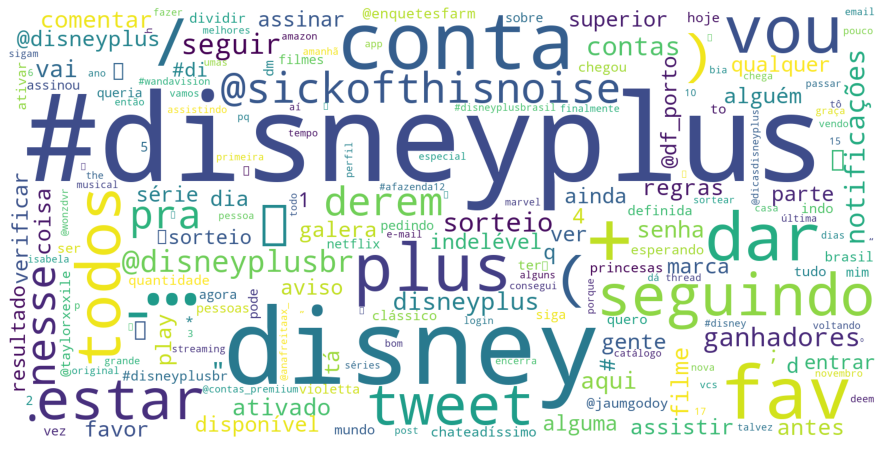

In [155]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

wordcloud = WordCloud(background_color='white', width=1600,                            
                      height=800).generate_from_frequencies(word_frequency)

#Plotting the image

fig, ax = plt.subplots(figsize=(16,8))            
ax.imshow(wordcloud, interpolation='bilinear')       
ax.set_axis_off()
plt.imshow(wordcloud)